<a href="https://colab.research.google.com/github/burakayy7/ARIMA-model/blob/main/ARIMA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
  #installations
!pip install skforecast

# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from sklearn.linear_model import LinearRegression
# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.5 MB/s eta 0:00:00


In [ ]:
# Data download
# ==============================================================================
data = fetch_dataset(name='h2o_exog', raw=True) #this dataset is on australian health system, from 1991 to 2008. This is from Hyndman (2023) fpp3
#Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are simulated.

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

<Axes: xlabel='date'>

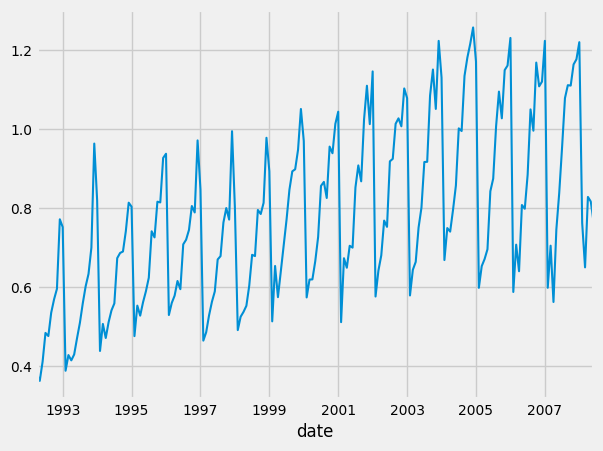

In [ ]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()
#data.head()

data = data.y

data.plot()


<Axes: xlabel='date'>

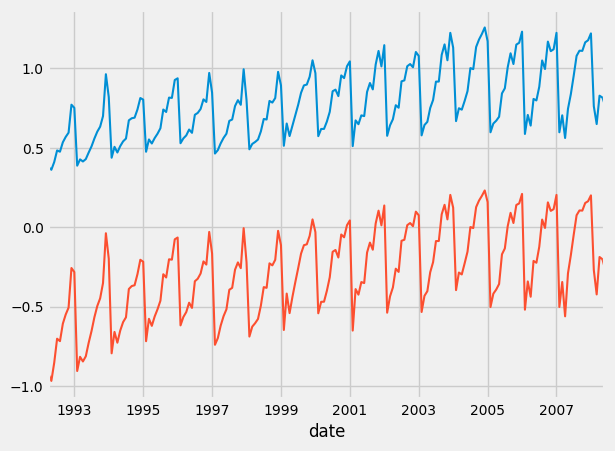

In [ ]:
#Data Transformations
def get_sign(num):
  if (num < 0):
    return -1
  return 1

def bickel_doksum_transform(data, lam):
  new_data = data.copy()
  if (lam == 0):
    for i in range(len(data)):
      new_data.iloc[i] = np.log(data.iloc[i])
  else:
    for i in range(len(data)):
      new_data.iloc[i] = (get_sign(data.iloc[i])*(pow(abs(data.iloc[i]), lam)-1))/lam
  return new_data

t_data = bickel_doksum_transform(data, .1)
data.plot()
t_data.plot()


In [ ]:
data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199
...,...,...,...
2008-02-01,0.761822,1.515840,1.786373
2008-03-01,0.649435,1.506258,1.694264
2008-04-01,0.827887,1.505253,1.627135


<Axes: xlabel='date'>

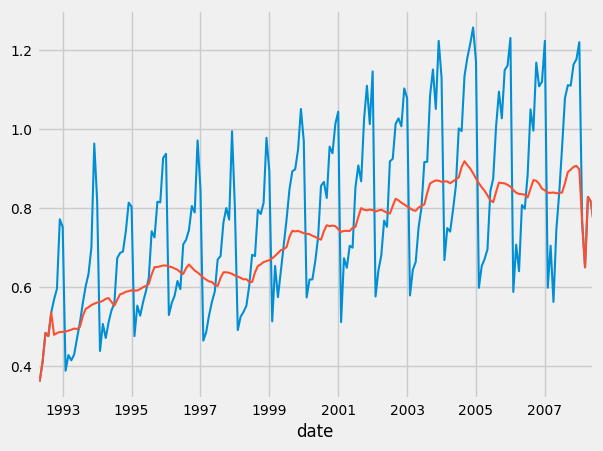

In [ ]:
def moving_average(data, order):
  new_data = data.copy()
  length = len(data)
  k = int((order-1)/2)
  for i in range(length):
    if (i > k and i < length-k):
      if (order % 2 == 1):
        sum = 0
        for j in range(i-k, i+k):
          sum += data.iloc[j]
        avg = sum/order
        new_data.iloc[i] = avg
      else:
        sum1 = 0
        sum2 = 0
        for j in range(i-k-1, i+k):
          sum1 += data.iloc[j]
        avg1 = sum1/order
        for j in range(i-k, i+k+1):
          sum2 += data.iloc[j]
        avg2 = sum2/order
        new_data.iloc[i] = (avg1+avg2)/2
  return new_data


ma_data = moving_average(data, 12)
data.plot()
ma_data.plot()

195


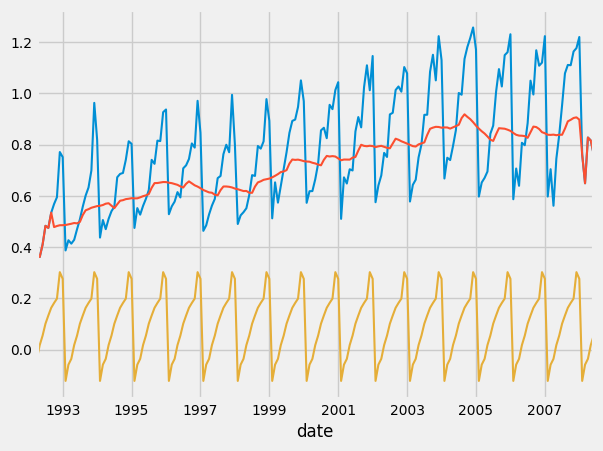

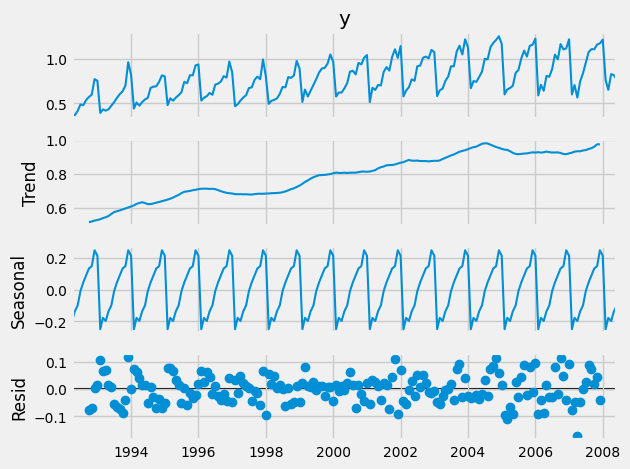

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
def additive_de_trend(data, order):
  new_data = data.copy()
  length = len(data)
  k = int((order-1)/2)
  for i in range(length):
    if (i > k and i < length-k):
      if (order % 2 == 1):
        sum = 0
        for j in range(i-k, i+k):
          sum += data.iloc[j]
        avg = sum/order
        new_data.iloc[i] = data.iloc[i] - avg
      else:
        sum1 = 0
        sum2 = 0
        for j in range(i-k-1, i+k):
          sum1 += data.iloc[j]
        avg1 = sum1/order
        for j in range(i-k, i+k+1):
          sum2 += data.iloc[j]
        avg2 = sum2/order
        new_data.iloc[i] = data.iloc[i] - ((avg1+avg2)/2)
  return new_data

def seasonal_comp(data, order):
  new_data = data.copy()
  seasonal_components = pd.DataFrame(index = range(order), columns=['y'])
  de_trended_data = additive_de_trend(data, 12)
  for i in range(order):
    sum = 0
    count = 0
    index = i
    while index < len(de_trended_data):
      sum += de_trended_data.iloc[index]
      count += 1
      index += order
    seasonal_components.y.iloc[i] = (sum/count)
  place = 0
  for i in range(len(data)):
    new_data.iloc[i] = seasonal_components.y.iloc[place]
    place += 1
    if place >= order:
      place = 0
  return new_data

ad_data = additive_de_trend(data, 20)
season_comps = seasonal_comp(data, 12)
data.plot()
#ad_data.plot()
trend_comp = moving_average(data, 12)
trend_comp.plot()
season_comps.plot()
decomposition = seasonal_decompose(data)

# Plot the components
decomposition.plot()
sum1 = 0
for i in range(len(season_comps)):
  sum1 += season_comps.iloc[i]
print(len(data))

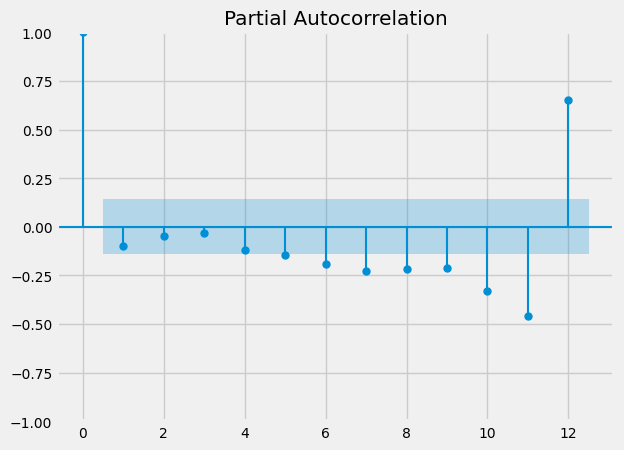

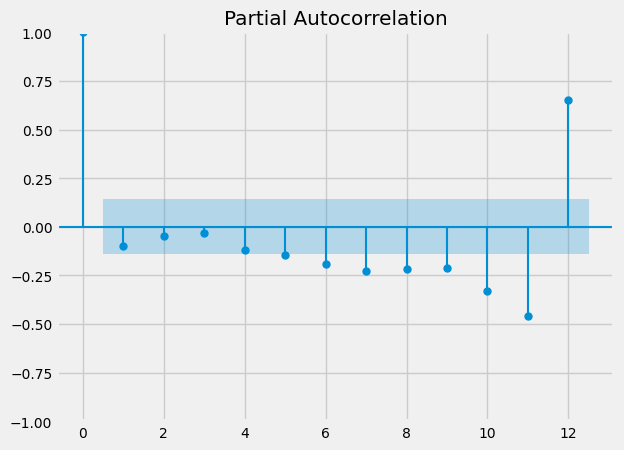

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
def seasonal_difference(data, seasons):
  new_data = data.copy()
  for i in range(len(data)):
    if (i >= seasons):
      new_data.iloc[i] = data.iloc[i] - data.iloc[i-seasons]
  return new_data
seasonal_dif_data = seasonal_difference(data, 12)
difference_data = seasonal_difference(data, 1)
#difference_data.plot()
plot_pacf(difference_data, lags=12)
#seasonal_dif_data.plot()

[0.0003504248529876986, 0.0003504248529876986, 0.0003504248529876986, 0.0003504248529876986, 0.0003504248529876986, 0.0003504248529876986, 0.0003504248529876986, 0.0003504248529876986, 0.0003504248529876986, 0.0003504248529876986, 0.0003504248529876986, 0.0003504248529876986]
0.00977796319735638
[0.032906003494544485, 0.03711110173039687, 0.04131619996624926, 0.04552129820210164, 0.049726396437954026, 0.05393149467380641, 0.058136592909658794, 0.06234169114551117, 0.06654678938136355, 0.07075188761721594, 0.07495698585306831, 0.07916208408892071, 0.08336718232477308, 0.08757228056062547, 0.09177737879647786, 0.09598247703233023, 0.10018757526818262, 0.104392673504035, 0.10859777173988738, 0.11280286997573977, 0.11700796821159215, 0.12121306644744453, 0.12541816468329692, 0.1296232629191493, 0.13382836115500168, 0.13803345939085407, 0.14223855762670645, 0.14644365586255884, 0.15064875409841122, 0.1548538523342636, 0.15905895057011596, 0.16326404880596834, 0.16746914704182073, 0.17167424

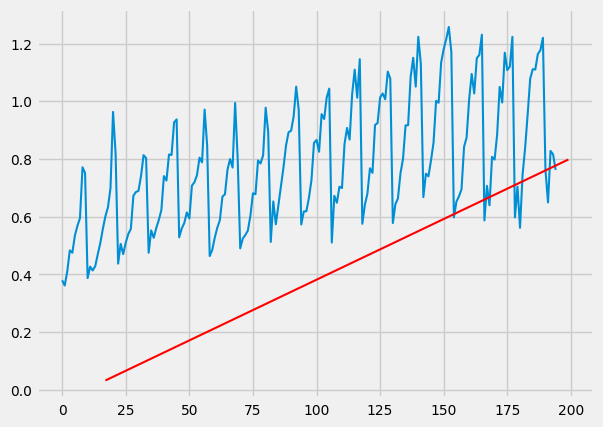

In [ ]:
from pandas.plotting import lag_plot
'''def auto_regressive(xs, ys, learning_rate, epoch, p):
  assert len(xs) == len(ys)
  beta = [0 for _ in range(p)]
  for e in range(epoch):
    for start in range(len(xs)):
      if (start >= p and start <= len(xs)):
        batch_xs = xs[start-p:start]
        batch_ys = ys[start]
        for b_i in range(len(beta)):
          #error
          error = 0
          #for i in range(start-p, start):
            #error += xs[i]*beta[i-start+p]
            #print(error)
          for i in range(len(batch_xs)):
            error += batch_xs[i]*beta[i]
          error -= batch_ys
          #print(error)
          beta[b_i] -= learning_rate*(2*batch_xs[b_i]*error)
    #print(beta)
  return beta'''
def auto_regressive(xs, ys, learning_rate, epoch, p):
  assert len(xs) == len(ys)
  beta = [0 for _ in range(p)]
  bias = 0
  for e in range(epoch):
    count = 0
    error_sum = 0
    error = 0
    for start in range(len(xs)):
      error = 0
      if (start >= p): #and start <= len(xs)):
        batch_xs = xs[start-p:start]
        #print(start, batch_xs)
        batch_ys = ys[start]
        count += 1

        for i in range(len(batch_xs)):
          error += batch_xs[i]*beta[i]
        error += bias
        error -= batch_ys
        #print(count)
        for b_i in range(len(beta)):
          beta[b_i] -= learning_rate*(2*xs[start-p]*error)/count
        bias -= learning_rate*(2*error)/count
    #print(beta)
  return beta, bias
def prepare_data(data, order):
  X, y = [], []
  for i in range(order, len(data)):
    X.append(data[i - order:i])
    y.append(data[i])
  return np.array(X), np.array(y)
'''def auto_regressive(data, learning_rate, epoch, p):
  assert len(xs) == len(ys)
  beta = [0 for _ in range(p)]
  bias = 0
  X, y = prepare_data(data)
  for e in range(epoch):
    count = 0
    error = 0
    errors = []
    for j, batch_xs in enumerate(X):
      for i, b_xs in enumerate(batch_xs):
        error += b_xs*beta[i]
      error += bias
      errors.append(error-y[j])
        #print(count)
    for b_i in range(len(beta)):
      beta[b_i] -= learning_rate*(2*xs[b_i]*error)/count
    bias -= learning_rate*(2*error)/count
    #print(beta)
  return beta, bias'''
x = []
y = []
#lag_plot(data)
new_data = data
for i in range(len(new_data)):
  x.append(i)
  y.append(new_data.iloc[i].item())
  #print(type(data.iloc[i]))
p = 12
be, bias = auto_regressive(x[12:], y[12:], 0.0001, 100, p)
print(be)
print(bias)
plt.plot(x, y)
x_lag = []
y_lag = []
def sum_of_array(arr):
  sum = 0.0
  for num in arr:
    sum += num
  return sum
for i in range(len(x)):
  if i >= p:
    #y_lag.append(sum([be[j-i+p] * x[j] for j in range(i-p, i)]))
    y_lag.append(sum_of_array([be[j-i+p] * x[j] for j in range(i-p, i)])+bias)
print(y_lag)
#plt.plot(list(np.arange(0, 2, .01)), [be[i]*x_lag[i] + be[i]*x_lag[i] for x in np.arange(0, 2, .01)], color="red")
num = .05+(p*.01)
plt.plot(list(np.arange(17, 200, 1)), y_lag, color="red")

In [ ]:
# create and evaluate a static autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from sklearn.metrics import squared_error

from math import sqrt
# load dataset
series = data
# split dataset
X = series.values
train, test = X[0:len(X)-12], X[len(X)-12:]
# train autoregression
model = AutoReg(train, lags=12)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
 print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


ImportError: cannot import name 'squared_error' from 'sklearn.metrics' (/usr/local/lib/python3.10/dist-packages/sklearn/metrics/__init__.py)

In [ ]:
class ARIMA(object):
    def __init__(self):
        pass

    @staticmethod
    def _regressor(df, n, val_col, out_pred_col, train_size=0.8):
        _df = df.copy()

        #Generating the lagged n terms
        for i in range(1, n + 1):
            _df[f'shifted_values_{i}'] = _df[val_col].shift(i)
        _df.dropna(inplace=True)


        _train_size = int(train_size * _df.shape[0])

        #Breaking data set into test and training
        _df_train = pd.DataFrame(_df[:_train_size])
        _df_test = pd.DataFrame(_df[_train_size:])

        #X contains the lagged values ,hence we skip the first column
        X_train = _df_train.iloc[:, 1:].values.reshape(-1, n)
        #Y contains the value, it is the first column
        y_train = _df_train.iloc[:, 0].values.reshape(-1, 1)

        # We do the same thing with the test set
        X_test = _df_test.iloc[:, 1:].values.reshape(-1, n)
        y_test = _df_test.iloc[:, 0].values.reshape(-1, 1)

        #Running linear regression to generate the coefficents of lagged terms
        lr = LinearRegression()
        lr.fit(X_train, y_train)

        theta  = lr.coef_.T
        #print(theta)
        intercept = lr.intercept_
        _df_train[out_pred_col] = X_train.dot(theta) + intercept
#         _df_train[[val_col, out_pred_col]].plot()

        _df_test[out_pred_col] = X_test.dot(theta) + intercept
#         _df_test[[val_col, out_pred_col]].plot()

        rmse = np.sqrt(mean_squared_error(y_test, _df_test[out_pred_col]))

#         print(f'RMSE = {rmse}. Value of n = {n}')
        new_df = pd.concat([_df_train, _df_test])[[val_col, out_pred_col]]
        return new_df, theta, intercept, rmse, np.abs(_df_test[out_pred_col].mean())

    @staticmethod
    def AR(df, p, val_col='y', out_pred_col='predicted_value', train_size=0.8):
        return ARIMA._regressor(df, p, val_col, out_pred_col, train_size)

    @staticmethod
    def I(df, val_col='y', fn=None):
        _df = df.copy()
        if fn is not None:
            return pd.DataFrame(fn(_df[val_col])).dropna()
        return _df

    @staticmethod
    def MA(df, q, val_col='y', in_pred_col='predicted_value', out_pred_col='ma_predicted_value', train_size=0.8):
        _df = df.copy()
        _df['residual'] = _df[val_col] - _df[in_pred_col]
        return ARIMA._regressor(_df[['residual']], q, 'residual', out_pred_col, train_size)


    def fit(self, df, p, q, val_col, train_size, stationary_fn=None):
        _df = df.copy()
        stationary_df = ARIMA.I(_df, val_col, stationary_fn)
#         stationary_df[val_col].plot()
#         plt.show()

        ar_out_df, ar_theta, ar_intercept, ar_rmse, ar_mean_pred = ARIMA.AR(stationary_df, p, val_col, 'ar_predicted_value', train_size)
#         print(ar_rmse)
#         ar_out_df['ar_predicted_value'].plot()
#         plt.show()

        ma_out_df, ma_theta, ma_intercept, ma_rmse, ma_mean_pred = ARIMA.MA(ar_out_df, q, val_col, 'ar_predicted_value', 'ma_predicted_value', train_size)
#         print(ma_rmse)
#         ma_out_df['ma_predicted_value'].plot()
#         plt.show()

#         final_predictions = (ar_out_df['ar_predicted_value'] + ma_out_df['ma_predicted_value']).dropna()
#         final_predictions.plot()

#         return final_predictions
        stationary_df['prediction'] = ar_out_df['ar_predicted_value']# + ma_out_df['ma_predicted_value']
        return stationary_df.dropna(), ar_theta, ar_intercept, ma_theta, ma_intercept, ar_rmse, ma_rmse, ar_mean_pred, ma_mean_pred

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[-0.50276143]]
[[-0.2053195]]
[[-0.6968863 ]
 [-0.42157997]]
[[-0.06666345]]
[[-0.76354975]
 [-0.56215179]
 [-0.20369915]]
[[-0.02686633]]
[[-0.78948388]
 [-0.63518773]
 [-0.31031411]
 [-0.14288674]]
[[-0.02522733]]
[[-0.81355684]
 [-0.68663913]
 [-0.42440959]
 [-0.29236995]
 [-0.19208284]]
[[-0.01177899]]
[[-0.82514246]
 [-0.7038996 ]
 [-0.4504496 ]
 [-0.33652687]
 [-0.24640786]
 [-0.06697593]]
[[-0.01023654]]
[[-0.83483365]
 [-0.7390183 ]
 [-0.50316155]
 [-0.40696931]
 [-0.36074141]
 [-0.20444204]
 [-0.16397485]]
[[-0.02589887]]
[[-0.86073252]
 [-0.76809624]
 [-0.57984513]
 [-0.49842791]
 [-0.47231973]
 [-0.36062108]
 [-0.34029495]
 [-0.20564015]]
[[-0.02450557]]
[[-0.88513982]
 [-0.78922963]
 [-0.60308103]
 [-0.53174051]
 [-0.50962259]
 [-0.41199507]
 [-0.40711618]
 [-0.28269559]
 [-0.09439882]]
[[-0.01174871]]
[[-0.89634008]
 [-0.82841553]
 [-0.66055157]
 [-0.59203015]
 [-0.58523287]
 [-0.49445131]
 [-0.50213908]
 [-0.41191226]
 [-0.2379317 ]
 [-0.16206374]]
[[-0.14428935]]
[[-1.0

<Axes: xlabel='date'>

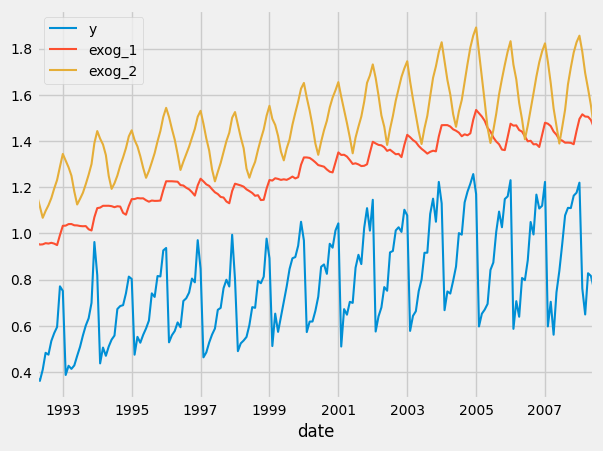

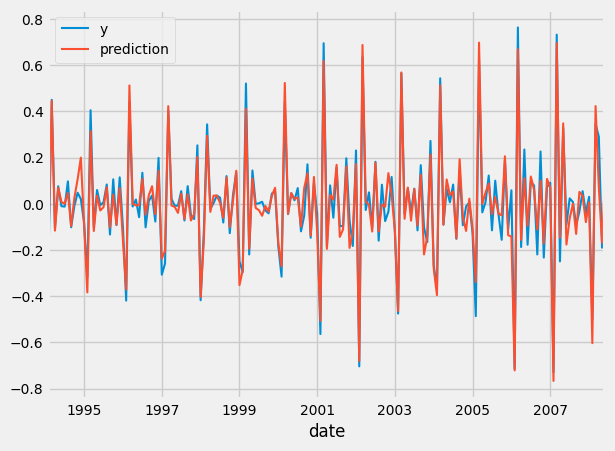

In [ ]:
TRAIN_SIZE = 0.8
arima_model = ARIMA()
stationary_fn = lambda x: x.diff().diff()
def reverse_stationary_fn(ori_x, new_x):
    x = new_x.copy()
    x += ori_x.shift(1)
    x += ori_x.diff().shift(1)
    return x

min_ar_rmse = float('inf')
min_ma_rmse = float('inf')
best_ar_mean_pred = None
best_ma_mean_pred = None
best_p = 1
best_q = 1

for i in range(1, 21):
    final_predictions, \
        ar_theta, ar_intercept, \
        ma_theta, ma_intercept, \
        ar_rmse, ma_rmse, \
        ar_mean_pred, ma_mean_pred = arima_model.fit(data, i, best_q, val_col='y', train_size=TRAIN_SIZE, stationary_fn=stationary_fn)

    if ar_rmse < min_ar_rmse:
        min_ar_rmse = ar_rmse
        best_ar_mean_pred = ar_mean_pred
        best_p = i
#print(ar_theta)
data.plot()
reverse_stationary_fn(final_predictions.plot()

In [ ]:
df_c.Value += np.log(df).shift(1).Value
df_c.Value += np.log(df).diff().shift(12).Value
df_c.Predicted_Values += np.log(df).shift(1).Value
df_c.Predicted_Values += np.log(df).diff().shift(12).Value
df_c.Value = np.exp(df_c.Value)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

In [ ]:
data_partition = (int) (.8*data.shape[0])
y_train = data[:-data_partition]
y_test = data[-data_partition:]